https://github.com/karpathy/micrograd

- Go to the micrograd github and briefly talk through it
- Explain the purpose of .backward and how it starts a back prop from the node it is called on
- Backprop recursively applies the chain rule to calculate the gradients 
- Explain what the gradient tells us
- This same process can be used to train NNs

NNs are a mathematical expression, which takes in the input data and the weights of a NN as inputs and output are the preditions of the NN/ the loss function

Backpropogation is a general method, it deals with arbitrary mamethamitcal expressions. Backprop allows us to efficiently compute the gradient of some loss function
w.r.t to the weights of a NN, allowing us to iteratively tune the NN to minimise the loss function. 

We will build a simple NN package, following Andrej's method, called Micrograd. It is a very small library with ony around 150 lines of code.
This package will enable us to train neural networks and understanding the foundations and inner workings of the code behind training neural networks.

First, lets build an intuitive understanding of what a derivative is and what information it gives to us.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# lets define a simple function
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
# We can plot this function to get its shape, it will be a parabola (quadratic)
xs = np.arange(-5, 5, 0.25)
# This creates a numpy array of numbers from -5 to 5, not including 5, with a step size of 0.25
# We can also call the function on the array of xs to get a list of ys
ys = f(xs)

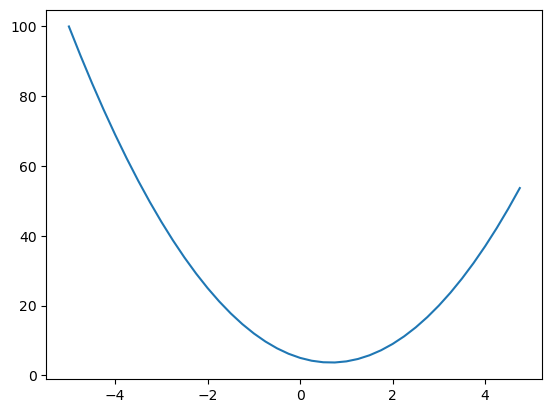

In [5]:
plt.plot(xs, ys)

Derivative of the function: y = 3x^2 -4x + 2

dy/dx = 6x - 4

Now, what is the derivative at any single input point x? We know how to do this the way we do in class, but writing out the expression is not something which 
is done with neural nets as the expression would simply be too large. Instead, we will understand the definition of a derivative and what it is telling us.


In [6]:
h = 0.0001
x = 3.0

# Before running examine the graph and ask do you expect the output to increase or decrease
f(x+h)

20.001400030000006

In [7]:
# This tells us how much the function responded by
f(x+h) - f(x)

0.0014000300000063248

In [8]:
# We the normalise by h (rise over run), to get the slope
(f(x+h) - f(x)) / h
# The number gotten is just a numerical approximation of the derivative. 
# Due to the way computers handle numbers if we make H very small we get 0
# QUESTION: What happens if we keep reducing size of 0 - Explore effects of floating point integers

14.000300000063248

In [9]:
# Now what about the slope at x=-3 and what is the sign of the slope?
h = 0.0001
x = -3.0

# Before running examine the graph and ask do you expect the output to increase or decrease
(f(x+h) - f(x)) / h

-21.999700000066014

In [10]:
# Now what about the slope at around 0 and what is the sign of the slope?
h = 0.000001
x = 2/3

# Before running examine the graph and ask do you expect the output to increase or decrease
(f(x+h) - f(x)) / h

2.999378523327323e-06

Following on from this let's see these ideas in action on a mathematical expression, before we go ahead and figure out how to do it ourselves. Here we train a simple neural network to fit to the function f(x) = 3x^2 - 4x + 5

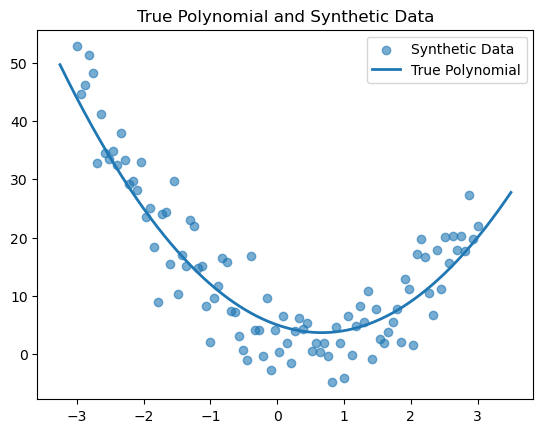

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Define polynomial function: f(x) = 3x^2 - 4x + 5
def true_polynomial(x):
    return 3*x**2 - 4*x + 5

# Generate synthetic data
np.random.seed(0)
x_data = np.linspace(-3, 3, 100)
# We create some x's from -3 to 3 and use these to generate our y's this is the synthetic data
y_data = true_polynomial(x_data) + np.random.normal(scale=5, size=len(x_data))

# Plot the true polynomial and synthetic data
plt.scatter(x_data, y_data, label='Synthetic Data', alpha=0.6)
x_range = np.linspace(-3.25, 3.5, 400)
plt.plot(x_range, true_polynomial(x_range), label='True Polynomial', linewidth=2)
plt.legend()
plt.title('True Polynomial and Synthetic Data')
plt.show()

In [23]:
!pip install torch
import torch
import torch.nn as nn
import torch.optim as optim

# Define neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = self.layer2(x)
        return x

# Initialize model, loss function, and optimizer
input_dim, hidden_dim, output_dim = 1, 50, 1
model = SimpleNN(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Convert data to PyTorch tensors
x_tensor = torch.FloatTensor(x_data).view(-1, 1)
y_tensor = torch.FloatTensor(y_data).view(-1, 1)

The way to think about what I am about to show is this, in each epoch we optimise the function by bumping the weights of the neurons using the gradients of a neural network. The way in which weights are bumped is according to Stochastic Gradient Descent. We then repeat the backward pass and continue to optimise, what we are basing the optimisation on is the MSE loss function and our goal is to minimise it. We compare the output of the models y_preds, to get this output we feed in the x_data (the values from -3 to 3), to the actual data given by y_data.

Essentially given the input X's how close can we get using our neural network to the y_data where y_data is a noisy representation of the true underlying polynomial.

We will work to implement the backward function, this is the key in the whole cycle without this the optimisation would not be possible. Let's think about this for a minute, we have this expression with 1 output and 50 inputs to it. How would we efficiently figure out how to change the inputs to minimise the output? The idea is we need to change the inputs but how can we know how much to change them and in what way to change them?

Epoch 0, Loss: 382.79425048828125


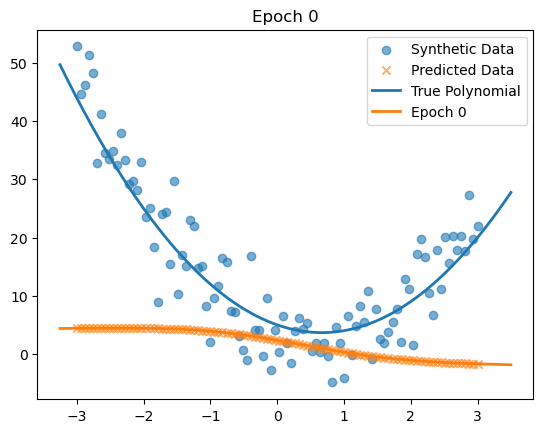

Epoch 50, Loss: 54.75352096557617


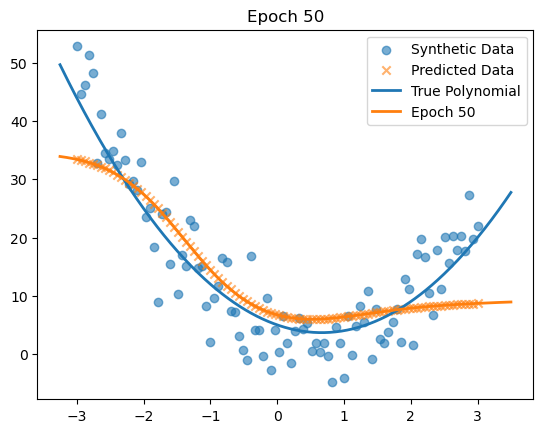

Epoch 100, Loss: 32.20481491088867


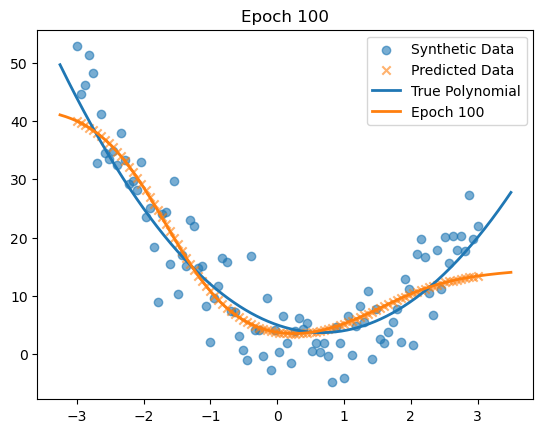

Epoch 150, Loss: 26.9294376373291


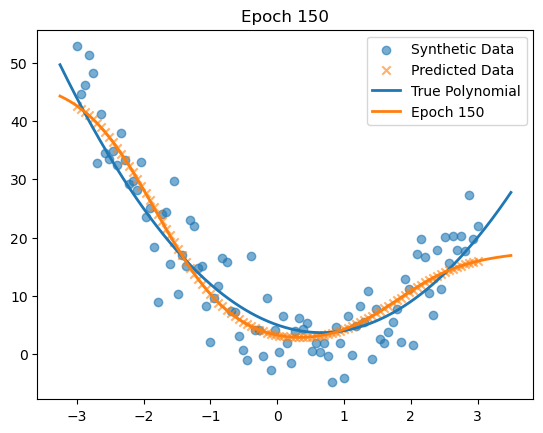

Epoch 250, Loss: 23.35638999938965


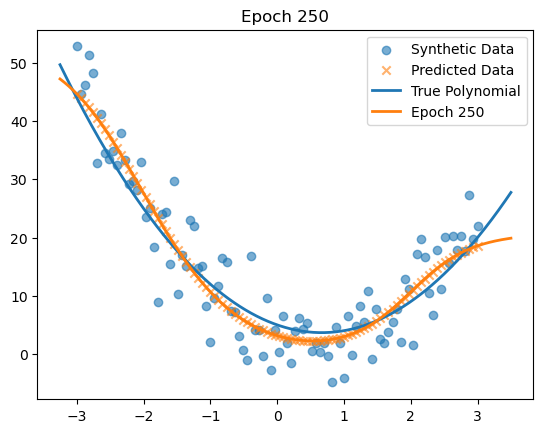

Epoch 500, Loss: 21.681690216064453


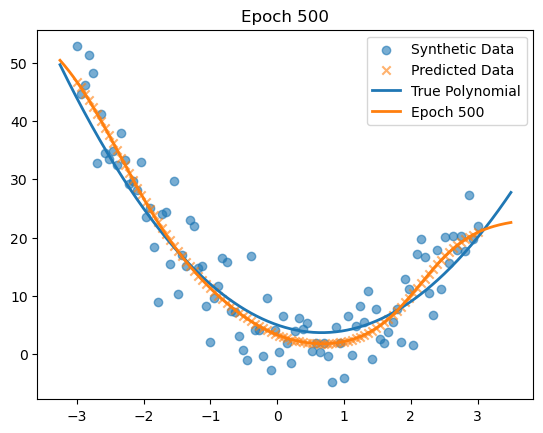

Epoch 1000, Loss: 21.211891174316406


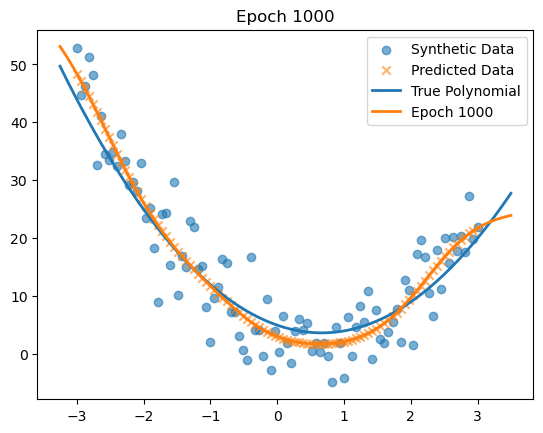

Epoch 2000, Loss: 21.07925796508789


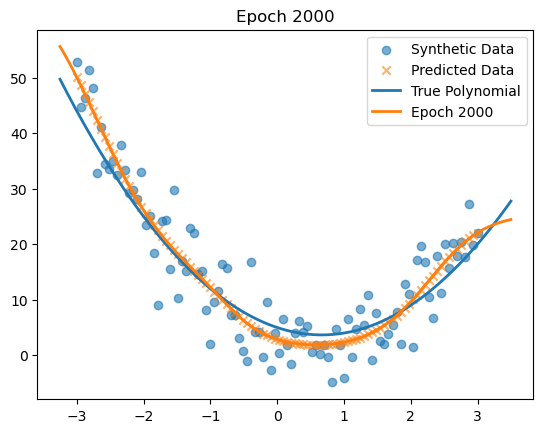

In [24]:
# Initialize lists to store plots
plots = []

# Training loop
epochs = 2001
for epoch in range(epochs):
    # Forward pass
    y_pred = model(x_tensor)
    loss = criterion(y_pred, y_tensor)  # here we compare the predicted y's of our network to the actual y's
    
    # Zero gradients, backward pass, optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Visualization at specific epochs
    if epoch in [0, 50, 100, 150, 250, 500, 1000, 2000]:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        with torch.no_grad():
            y_pred_range = model(torch.FloatTensor(x_range).view(-1, 1)).numpy()
            y_pred_data = model(x_tensor).numpy()
        
        plt.scatter(x_data, y_data, label='Synthetic Data', alpha=0.6)
        plt.scatter(x_data, y_pred_data, label='Predicted Data', alpha=0.6, marker='x')
        plt.plot(x_range, true_polynomial(x_range), label='True Polynomial', linewidth=2)
        plt.plot(x_range, y_pred_range, label=f'Epoch {epoch}', linewidth=2)
        plt.legend()
        plt.title(f'Epoch {epoch}')
        plt.show()


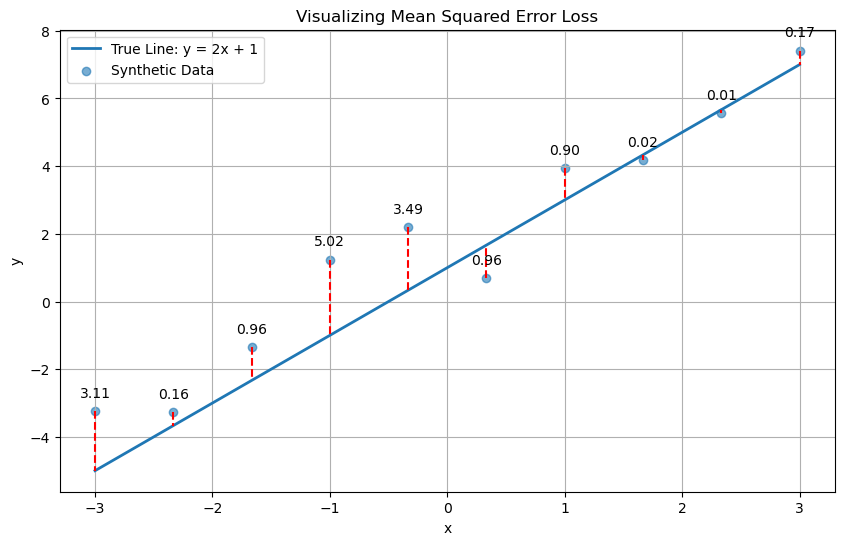

Mean Squared Error (MSE) Loss: 1.4799204010329265


In [25]:
# Generate synthetic data around the line y = 2x + 1
np.random.seed(0)
x_example = np.linspace(-3, 3, 10)
y_true_example = 2 * x_example + 1
y_synthetic_example = y_true_example + np.random.normal(scale=1, size=len(x_example))

# Calculate predicted y using the true function
y_pred_example = 2 * x_example + 1

# Calculate squared errors
squared_errors = (y_synthetic_example - y_pred_example)**2

# Plotting
plt.figure(figsize=(10, 6))

# Plot true line
plt.plot(x_example, y_true_example, label='True Line: y = 2x + 1', linewidth=2)

# Plot synthetic data points
plt.scatter(x_example, y_synthetic_example, label='Synthetic Data', alpha=0.6)

# Plot squared errors as vertical lines
for i in range(len(x_example)):
    plt.plot([x_example[i], x_example[i]], [y_synthetic_example[i], y_pred_example[i]], 'r--')

# Annotate squared errors
for i, txt in enumerate(squared_errors):
    plt.annotate(f'{txt:.2f}', (x_example[i], y_synthetic_example[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Visualizing Mean Squared Error Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate MSE loss
mse_loss = np.mean(squared_errors)
print(f"Mean Squared Error (MSE) Loss: {mse_loss}")


$$\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$$

From the formula we see the MSE is calculated by taking the difference between the predicted values and the actual values we are predicting for. In our case it is the difference between the predicted y_value at each point versus the actual y_value

In [15]:
# Moving to NNs due to the size of the expression we need to create some data structure 
# which will hold the expression. We will build a Value object to do so

<h3>Starting to build the Value object</h3>

In [16]:
class Value:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        # Ask if people understand what this method is doing, demonstrate what happens if we dont use it
        return f"Value(data={self.data})"

a = Value(2.0)
b = Value(-3.0)
a

Value(data=2.0)

In [17]:
class Value:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Ask the class to build out the operator overloads
    def __add__(self, other):
        # What does this method do? We access the data of the Value objects and use python addition on them 
        # returning a Value object
        out = Value(self.data + other.data)
        return out
    
    # Demo the add first then add the mul
    # Ask class how would we define the mul method?
    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
# a + b
# This is equivalent to a.__add__(b)
# a * b
a * b + c

Value(data=4.0)

In [18]:
# Now we are missing the connective tissue of the expression. As we mentioned earlier we need to know which 
# values are used to create other values.
# We do so by creating a new variable in the Value object called children

# We also need to know which operation created the Value, this is kept track of by the variable _op

In [19]:
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children) # We use a set for efficiency
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data})"
    
    # So now when we create a new Value object through addition or multiplication we will feed in the children
    # Value objects, i.e. the  Value objects used to create the new one
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') # Add the '+' and '*' after demoing the children
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b + c
# Now we can see the Values used to create d, namely the output of a*b and c
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [20]:
d._op

'+'

Now as the expressions may get quite big it is useful to be able to visualize them simply. To do so we can use graphviz. We can call draw_dot on a root node and it will create a graph of the expression.

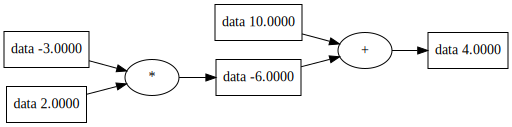

In [159]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{data %.4f}" % (n.data,), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

draw_dot(d)

In [155]:
# Lets add a label which will aid with the visualization of the nodes
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'

d = e + c; d.label='d'

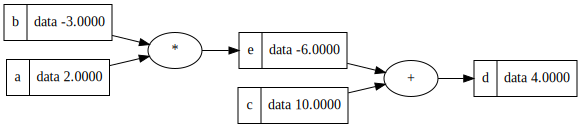

In [162]:
# Now add the label to the graph on line 24

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f}" % (n.label, n.data,), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

draw_dot(d)

In [164]:
# Lets add some depth to the expression and create a new Value f and the output will be L
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')

L = d * f; L.label='L'

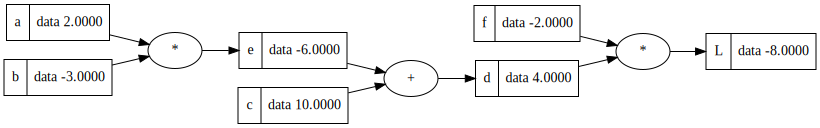

In [165]:
draw_dot(L)

So up to now we have the ability to build out mathematical expressions (which only use + and * for now) using the Value object. They are scalar valued and we can do the forward pass and get the output of the expression.
The next step is to run backpropogation on this expression and we do so by starting at the output L and computing the gradient at each node backwards w.r.t to L. So backpropogation will allow us to calculate the gradient of every node prior to L w.r.t to L.

In this expression we have just the values a,b,c,f but in a neural network setting you'd be very interested in the derivative of the loss function L w.r.t to the weights of the network which is what will be in our graph eventually. And then we need to know how each of these weights impacts the output L, so essentially we will be interested in the derivative of L w.r.t to some of its leaf nodes, with these leaf nodes being the weights of the NN and the other leaf nodes will be the data itself, but we do not want to use the derivative of loss function w.r.t to data as it is usually fixed. So we use the derivative of L w.r.t to the weights and iterate on them to minimise the loss.

Lets review what we have done so far, we have the ability to build out mathematical expressions (+ and *) using the Value object. They are scalar valued and
we can do the forward pass and get the output of the expression. We now want to run the backpropagation on the expression, we do this by starting at L and computing
the gradient at each Value. This is done by taking the derivative of that node w.r.t L. 
This allows us to calculate the derivative of every node w.r.t to L.

In a neural network setting this is important as the derivative of L (loss function) w.r.t the weights of the network, here we just have variables a,b,c,f but 
some of these will eventually represent the weights of an NN and we will need to know how these weights affect the loss function. So we will be interested
in the derivative of the output w.r.t to some of its leaf nodes, with the leaf nodes being the weights of the NN. The other leaf nodes will be the data itself
but we will not want to use the derivative of L w.r.t to the data itself as it will be fixed. Whereas the weights will be iterated upon using the gradient we get from the backprop.

So now we will add a variable the Value class which holds the value of the derivative of L w.r.t to that value.

In [212]:
# We will now create a variable on the Value class which maintains the derivative of L w.r.t to that Value
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # At init we assume that every Value doesnt impact the output L
        self._prev = set(_children) # We use a set for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')

L = d * f; L.label='L'

In [2]:
# Now add the grad to the graph on line 24

# This grad shows the value of the derivative of L with respect to node n

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

draw_dot(L)

NameError: name 'L' is not defined

In [169]:
# So now we can manually do the backpropagation

# We start with L, so if we change L by some value how much does L change? It will be 1, we can estimate this
# using the same method as earlier

In [193]:
# We create an lol function so that we don't mess up the global scope, this is just for demonsatration and we
# do not want to change the actual values of these Value objects
def lol():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data
    
    # We will add the h value to the scalars, starting with a
    # so we will measure the derivative of L w.r.t a
    #a = Value(2.0+h, label='a')
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    #c = Value(10.0+h, label='c')
    e = a*b; e.label='e'
    #e.data += h
    d = e + c; d.label='d'
    #d.data += h
    f = Value(-2.0, label='f')
    #f = Value(-2.0+h, label='f')
    L = d * f; L.label='L'
    L2 = L.data
    # L2 = L.data + h use this to demo that derivative of L w.r.t to L will be 1
    
    print((L2-L1)/h)

lol()

0.0


In [214]:
# So now we can set L.grad to 1
L.grad = 1.0

Next lets look at L w.r.t to d and f starting with d

So:

L = d * f
dL / dd = f
Proof:
((d+h)*f - d*f) / h
(d*f + h*f - d*f) / h [d*f cancels]
(h*f)/h
f

So then what will dL / df be?
dL / df = d


In [215]:
d.grad = -2.0
f.grad = 4.0

# We can check this using the lol function, do so by bumping d and f by h

The next node is the most important gradient.

dL/dc

So how do we derive this? Well what do we know so far?

We know the value of dL/dd and how L is sensitive to changes in d, but how can we know how it is sensitive to changes in c through d?

We can calculate the impact c has on d so we need to combine this with the information of dL/dd to get dL/dc.

We start by getting the derivative of dd / dc
dd / dc = 1.0

d = c + e (what is the derivative of this?)

So then 

dd / de = 1.0

The local derivative of an addition is easy to calculate. The local derivative is just the derivatives of the node this node operates upon so d w.r.t c and e. But this is not what we want, we want dL/dc and dL/de.
So how do we combine dL/dd and dd/dc/e to get dL/dc?

The chain rule!!!

This gives us a very simple recipe to derive dL/ dc

Through the chain rule:
dL / dc = dL/dd * dd/dc

Thus:
dL/dc = -2.0 * 1.0
dL/de = -2.0 * 1.0

So the plus node just routes the gradient becuase the local derivative of any plus node will be equal to one.

In [216]:
c.grad = -2.0
e.grad = -2.0

We can now apply the chain rule again to a and b

So dL/de = -2.0

dL/da = dL/de * de/da

So now thinking about the local node
e = a * b

de/da = b
de/db = a

dL/da = -2.0 * -3.0 = 6.0

dL/db = -2.0 * 2.0 = -4.0

In [217]:
a.grad = 6.0
b.grad = -4.0

And that was how to manually backpropagate the expression we created earlier. So we iterated through the nodes and locally applied the chain rule, we always what is the derivative of L w.r.t to the current output and we look at how it was produced through its children nodes, take the local derivative and multiply them onto the derivative.
So backprop is basically just a recursive application of the chain rule. 

So we can now look at what this tells us by nuding our inputs in order increase value of L (i.e. make it less negative)

Any questions?

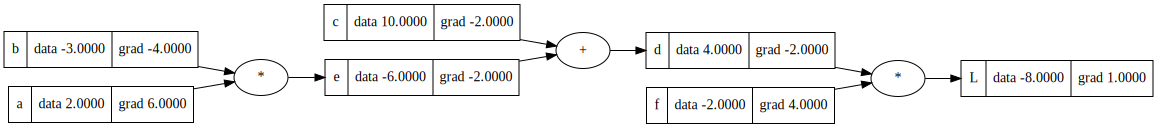

In [218]:
draw_dot(L)

In [221]:
# To increase L by nudging the nodes in the direction of its gradient
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b; e.label='e'
d = e + c; d.label='d'
#f = Value(-2.0, label='f')
L = d * f; L.label='L'; L.grad=1.0

print(L.data)

-7.286496


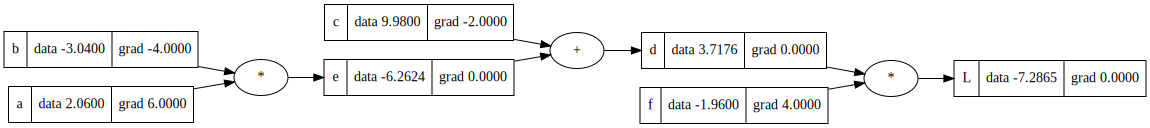

In [222]:
draw_dot(L)

<h1>END OF LESSON 1</h1>

<h3> Manual backprop of a neuron </h3>

A neuron is a mathematical function used in neural networks.

It has the function wx + b = y and it is passed through an activation function which is a squashing function.

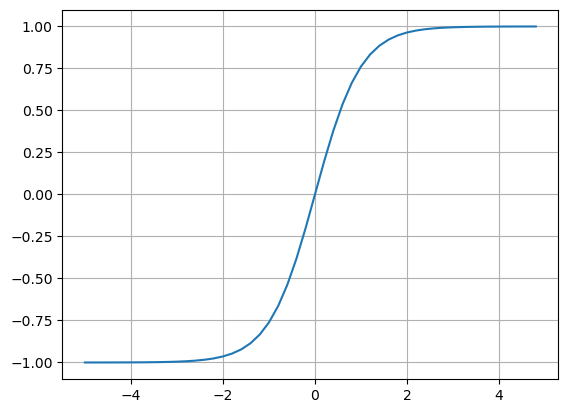

In [223]:
# What is tanh?
# We see how the inputs get squashed between 1 and 0. So very positive inputs will be capped at 1
# and very negative inputs will be capped at -1
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [13]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://wikimedia.org/api/rest_v1/media/math/render/svg/b8dc4c309a551cafc2ce5c883c924ecd87664b0f")


In [226]:
# We will now implement the tanh method
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # At init we assume that every Value doesnt impact the output L
        self._prev = set(_children) # We use a set for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    # We can create functions of arbitrary complexity in the Value class all we need to know is the local 
    # derivative of the function w.r.t to its inputs
    
    # Build out the tanh method 
    def tanh(self):
        x = ...
        t = ...  # This needs to implement the tanh function, you can use math.exp(x) which returns e raised
        # to the power x
        out = Value(...)
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) # Ask class to implement this method
        out = Value(t, (self, ), 'tanh')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')

L = d * f; L.label='L'

Before implemention tanh show why it is important and how it adds non-linearity

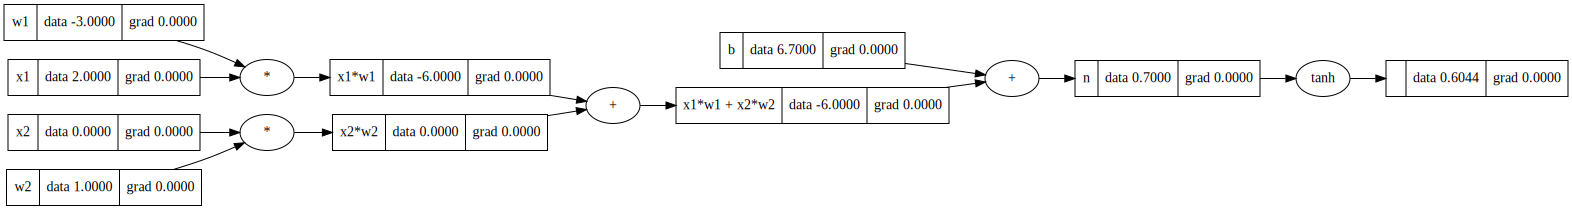

In [228]:
# Here is a simple 2d neuron 
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.7, label='b')
# x1*w1 + x2*w2 + b -> This is the part wx + b where wx is a vector of all inputs
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# We need to implement this tanh method to our Value class
o = n.tanh()

draw_dot(o)

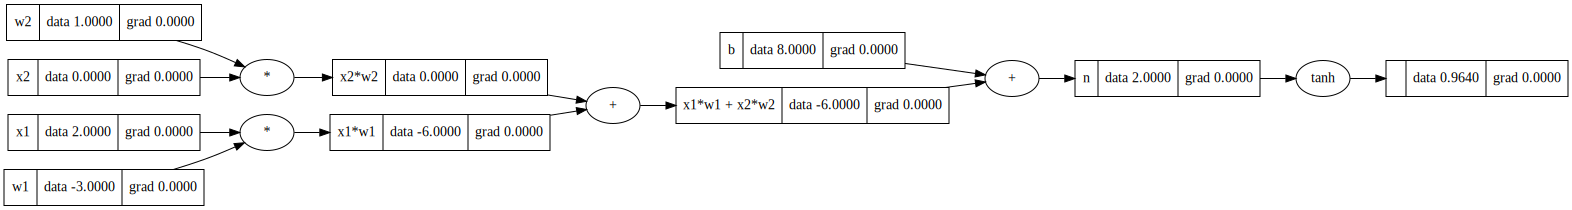

In [229]:
# Lets evaluate the effect of tanh currently it is not squashing much as the input to it is quite low
# We can do so by increasing the bias

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(8, label='b')
# x1*w1 + x2*w2 + b -> This is the part wx + b where wx is a vector of all inputs
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# We need to implement this tanh method to our Value class
o = n.tanh(); o.label='o'

draw_dot(o)

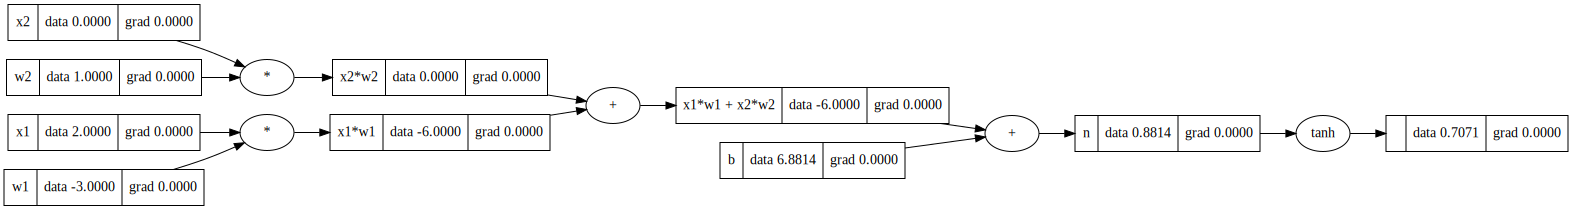

In [230]:
# We now change the bias to 6.8813735870195432 for our manual backprop, it will give us a nice number output

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b -> This is the part wx + b where wx is a vector of all inputs
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# We need to implement this tanh method to our Value class
o = n.tanh(); o.label='o'

draw_dot(o)

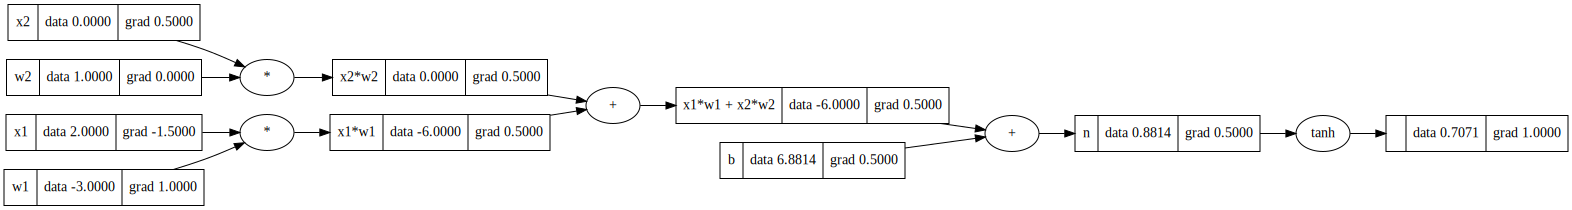

In [246]:
draw_dot(o)

In [231]:
# Now lets back propogate and fill out the outputs. In a neural network we care most about the derivative of 
# o w.r.t to the weights

# so what is do/do ?
o.grad = 1.0

In [234]:
# To backprop through o = tanh we need the local derivative of do/dn
# You could take the derivative of the equation for tanh but we will just use 1 - tanh^2 x
# so do/dn = 1-tanh(n)**2 and tanh(n) = o
# so do/dn = 1-o**2
n.grad = 1-o.data**2

In [236]:
# So at the plus node now what do we know from before? The gradient will just flow backwards due to the nature
# of the plus node so
x1w1x2w2.grad = n.grad
b.grad = n.grad

In [238]:
# Now we have another plus, so what happens? the gradient is distributed backwards again
x2w2.grad = x1w1x2w2.grad
x1w1.grad = x1w1x2w2.grad

In [245]:
# Now we get to the crux of the backpropagation
# do/dx2 = do/dx2w2 * dx2w2/dx2
# dx2w2 = x2 * w2
# dx2w2/dx2 = w2

# Knowing what we know from last time what is the gradient of x2 and w2?
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

# So we see that the gradient of w2 is 0 and we should think about why this is the case and what it is telling
# us? Well consider that the input x2 is 0 so if we wiggle the weight w2 it's not changing anything as we multiply
# it by 0

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

# So if the weight w1 increases the neurons output will increase by 1

<h1>END OF LESSON 1</h1>

In [ ]:
I need to cretae a story for these sessions, going quite fast